In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pprint

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

from tools import init_paths

from config import cfg
from config import update_config
from core.loss import JointsMSELoss
from core.function import validate
from utils.utils import create_logger

import dataset
import models

In [2]:
# modifying validate function

%load_ext autoreload
%autoreload 2

from core.function import AverageMeter
from core.function import _print_name_value
import numpy as np
import time
import os

from utils.transforms import flip_back
from core.evaluate import accuracy
from core.inference import get_final_preds
from utils.vis import save_debug_images


def my_validate(val_loader, val_dataset, model, criterion, output_dir,
             tb_log_dir, writer_dict=None):

    # switch to evaluate mode
    model.eval()
    
    with torch.no_grad():
        
        all_preds, all_boxes, losses,  acc, image_path, filenames, imgnums = predict_batch(val_loader,val_dataset,model,criterion,output_dir)

        name_values, perf_indicator = val_dataset.evaluate(
            cfg, all_preds, output_dir, all_boxes, image_path,
            filenames, imgnums
        )

        model_name = cfg.MODEL.NAME
        if isinstance(name_values, list):
            for name_value in name_values:
                _print_name_value(name_value, model_name)
        else:
            _print_name_value(name_values, model_name)

        if writer_dict:
            writer = writer_dict['writer']
            global_steps = writer_dict['valid_global_steps']
            writer.add_scalar(
                'valid_loss',
                losses.avg,
                global_steps
            )
            writer.add_scalar(
                'valid_acc',
                acc.avg,
                global_steps
            )
            if isinstance(name_values, list):
                for name_value in name_values:
                    writer.add_scalars(
                        'valid',
                        dict(name_value),
                        global_steps
                    )
            else:
                writer.add_scalars(
                    'valid',
                    dict(name_values),
                    global_steps
                )
            writer_dict['valid_global_steps'] = global_steps + 1

    return perf_indicator


def predict_batch(val_loader, val_dataset, model, criterion, output_dir):
    end = time.time()
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    num_samples = len(val_dataset)
    all_preds = np.zeros(
            (num_samples, cfg.MODEL.NUM_JOINTS, 3),
            dtype=np.float32
        )
    all_boxes = np.zeros((num_samples, 6))
    image_path = []
    filenames = []
    imgnums = []
    idx = 0
    for i, (input, target, target_weight, meta) in enumerate(val_loader):
            # compute output
            outputs = model(input)
            if isinstance(outputs, list):
                output = outputs[-1]
            else:
                output = outputs

            if cfg.TEST.FLIP_TEST:
                # this part is ugly, because pytorch has not supported negative index
                # input_flipped = model(input[:, :, :, ::-1])
                input_flipped = np.flip(input.cpu().numpy(), 3).copy()
                input_flipped = torch.from_numpy(input_flipped).cuda()
                outputs_flipped = model(input_flipped)

                if isinstance(outputs_flipped, list):
                    output_flipped = outputs_flipped[-1]
                else:
                    output_flipped = outputs_flipped

                output_flipped = flip_back(output_flipped.cpu().numpy(),
                                           val_dataset.flip_pairs)
                output_flipped = torch.from_numpy(output_flipped.copy()).cuda()


                # feature is not aligned, shift flipped heatmap for higher accuracy
                if cfg.TEST.SHIFT_HEATMAP:
                    output_flipped[:, :, :, 1:] = \
                        output_flipped.clone()[:, :, :, 0:-1]

                output = (output + output_flipped) * 0.5

            target = target.cuda(non_blocking=True)
            target_weight = target_weight.cuda(non_blocking=True)

            loss = criterion(output, target, target_weight)

            num_images = input.size(0)
            # measure accuracy and record loss
            losses.update(loss.item(), num_images)
            _, avg_acc, cnt, pred = accuracy(output.cpu().numpy(),
                                             target.cpu().numpy())

            acc.update(avg_acc, cnt)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            c = meta['center'].numpy()
            s = meta['scale'].numpy()
            score = meta['score'].numpy()

            preds, maxvals = get_final_preds(
                cfg, output.clone().cpu().numpy(), c, s)

            all_preds[idx:idx + num_images, :, 0:2] = preds[:, :, 0:2]
            all_preds[idx:idx + num_images, :, 2:3] = maxvals
            # double check this all_boxes parts
            all_boxes[idx:idx + num_images, 0:2] = c[:, 0:2]
            all_boxes[idx:idx + num_images, 2:4] = s[:, 0:2]
            all_boxes[idx:idx + num_images, 4] = np.prod(s*200, 1)
            all_boxes[idx:idx + num_images, 5] = score
            image_path.extend(meta['image'])

            idx += num_images

            if i % cfg.PRINT_FREQ == 0:
                msg = 'Test: [{0}/{1}]\t' \
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
                      'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time,
                          loss=losses, acc=acc)
                logger.info(msg)

                prefix = '{}_{}'.format(
                    os.path.join(output_dir, 'val'), i
                )
                save_debug_images(cfg, input, meta, target, pred*4, output,
                                  prefix)
    return all_preds, all_boxes, losses,  acc, image_path, filenames, imgnums 


In [3]:
def update_my_config():
    cfg.defrost()

    cfg.merge_from_file('experiments/mpii/hrnet/w32_256x256_adam_lr1e-3.yaml')

    opts = ["TEST.MODEL_FILE", "/mnt/models/HRNet/pose_mpii/pose_hrnet_w32_256x256.pth"]
    cfg.merge_from_list(opts)

    cfg.OUTPUT_DIR = "output_test"

    cfg.LOG_DIR = "log_test"

    cfg.freeze()

In [4]:
update_my_config()

logger, output_dir, tb_log_dir = create_logger(
    cfg, "experiments/mpii/hrnet/w32_256x256_adam_lr1e-3.yaml", 'valid')

#logger.info(pprint.pformat(args))
logger.info(cfg)
    
# cudnn related setting
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED

model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False
)

if cfg.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=False)
else:
    model_state_file = os.path.join(
        final_output_dir, 'final_state.pth'
    )
    logger.info('=> loading model from {}'.format(model_state_file))
    model.load_state_dict(torch.load(model_state_file))

model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()

# define loss function (criterion) and optimizer
criterion = JointsMSELoss(
    use_target_weight=cfg.LOSS.USE_TARGET_WEIGHT
).cuda()

# Data loading code
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
val_dataset = eval('dataset.'+cfg.DATASET.DATASET)(
    cfg, cfg.DATASET.ROOT, cfg.DATASET.TEST_SET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU*len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True
)

# evaluate on validation set
# my_validate(val_loader, val_dataset, model, criterion,
#             output_dir, tb_log_dir)

# switch to evaluate mode
model.eval()

with torch.no_grad():

    all_preds, all_boxes, losses,  acc, image_path, filenames, imgnums = predict_batch(val_loader, val_dataset, model, criterion, output_dir)

    name_values, perf_indicator = val_dataset.evaluate(
        cfg, all_preds, output_dir, all_boxes, image_path,
        filenames, imgnums
    )
        
model_name = cfg.MODEL.NAME
if isinstance(name_values, list):
    for name_value in name_values:
        _print_name_value(name_value, model_name)
else:
    _print_name_value(name_values, model_name)        

AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: True
  DATASET: mpii
  DATA_FORMAT: jpg
  FLIP: True
  HYBRID_JOINTS_TYPE: 
  NUM_JOINTS_HALF_BODY: 8
  PROB_HALF_BODY: -1.0
  ROOT: data/mpii/
  ROT_FACTOR: 30
  SCALE_FACTOR: 0.25
  SELECT_DATA: False
  TEST_SET: valid
  TRAIN_SET: train
DATA_DIR: 
DEBUG:
  DEBUG: True
  SAVE_BATCH_IMAGES_GT: True
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
GPUS: (0, 1, 2, 3)
LOG_DIR: log_test
LOSS:
  TOPK: 8
  USE_DIFFERENT_JOINTS_WEIGHT: False
  USE_OHKM: False
  USE_TARGET_WEIGHT: True
MODEL:
  EXTRA:
    FINAL_CONV_KERNEL: 1
    PRETRAINED_LAYERS: ['conv1', 'bn1', 'conv2', 'bn2', 'layer1', 'transition1', 'stage2', 'transition2', 'stage3', 'transition3', 'stage4']
    STAGE2:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4]
      NUM_BRANCHES: 2
      NUM_CHANNELS: [32, 64]
      NUM_MODULES: 1
    STAGE3:
      BLOCK: BASIC
      FUSE_MET

=> creating output_test/mpii/pose_hrnet/w32_256x256_adam_lr1e-3
=> creating log_test/mpii/pose_hrnet/w32_256x256_adam_lr1e-3_2019-10-31-21-02


=> loading model from /mnt/models/HRNet/pose_mpii/pose_hrnet_w32_256x256.pth
=> load 2958 samples
Test: [0/24]	Time 24.790 (24.790)	Loss 0.0005 (0.0005)	Accuracy 0.876 (0.876)
| Arch | Head | Shoulder | Elbow | Wrist | Hip | Knee | Ankle | Mean | Mean@0.1 |
|---|---|---|---|---|---|---|---|---|---|
| pose_hrnet | 97.101 | 95.941 | 90.336 | 86.449 | 89.095 | 87.084 | 83.278 | 90.330 | 37.702 |


In [5]:
print(all_preds.shape)
print(all_boxes.shape)
print(len(image_path))

(2958, 16, 3)
(2958, 6)
2958


## Analyzing results
`lib/dataset/mpii.py`

In [6]:
import numpy as np
from scipy.io import loadmat, savemat

from dataset.JointsDataset import JointsDataset
from collections import OrderedDict


def my_evaluate(cfg, preds, output_dir, *args, **kwargs):
    # convert 0-based index to 1-based index
    preds = preds[:, :, 0:2] + 1.0

    if output_dir:
        pred_file = os.path.join(output_dir, 'pred.mat')
        savemat(pred_file, mdict={'preds': preds})

    if 'test' in cfg.DATASET.TEST_SET:
        return {'Null': 0.0}, 0.0

    SC_BIAS = 0.6
    threshold = 0.5

    gt_file = os.path.join(cfg.DATASET.ROOT,
                           'annot',
                           'gt_{}.mat'.format(cfg.DATASET.TEST_SET))
    gt_dict = loadmat(gt_file)
    dataset_joints = gt_dict['dataset_joints']
    jnt_missing = gt_dict['jnt_missing']
    pos_gt_src = gt_dict['pos_gt_src']
    headboxes_src = gt_dict['headboxes_src']

    pos_pred_src = np.transpose(preds, [1, 2, 0])

    head = np.where(dataset_joints == 'head')[1][0]
    lsho = np.where(dataset_joints == 'lsho')[1][0]
    lelb = np.where(dataset_joints == 'lelb')[1][0]
    lwri = np.where(dataset_joints == 'lwri')[1][0]
    lhip = np.where(dataset_joints == 'lhip')[1][0]
    lkne = np.where(dataset_joints == 'lkne')[1][0]
    lank = np.where(dataset_joints == 'lank')[1][0]

    rsho = np.where(dataset_joints == 'rsho')[1][0]
    relb = np.where(dataset_joints == 'relb')[1][0]
    rwri = np.where(dataset_joints == 'rwri')[1][0]
    rkne = np.where(dataset_joints == 'rkne')[1][0]
    rank = np.where(dataset_joints == 'rank')[1][0]
    rhip = np.where(dataset_joints == 'rhip')[1][0]

    jnt_visible = 1 - jnt_missing
    uv_error = pos_pred_src - pos_gt_src
    uv_err = np.linalg.norm(uv_error, axis=1)
    headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
    headsizes = np.linalg.norm(headsizes, axis=0)
    headsizes *= SC_BIAS
    scale = np.multiply(headsizes, np.ones((len(uv_err), 1)))
    scaled_uv_err = np.divide(uv_err, scale)
    scaled_uv_err = np.multiply(scaled_uv_err, jnt_visible)
    jnt_count = np.sum(jnt_visible, axis=1)
    less_than_threshold = np.multiply((scaled_uv_err <= threshold),
                                      jnt_visible)
    PCKh = np.divide(100.*np.sum(less_than_threshold, axis=1), jnt_count)

    # save
    rng = np.arange(0, 0.5+0.01, 0.01)
    pckAll = np.zeros((len(rng), 16))

    for r in range(len(rng)):
        threshold = rng[r]
        less_than_threshold = np.multiply(scaled_uv_err <= threshold,
                                          jnt_visible)
        pckAll[r, :] = np.divide(100.*np.sum(less_than_threshold, axis=1),
                                 jnt_count)

    PCKh = np.ma.array(PCKh, mask=False)
    PCKh.mask[6:8] = True

    jnt_count = np.ma.array(jnt_count, mask=False)
    jnt_count.mask[6:8] = True
    jnt_ratio = jnt_count / np.sum(jnt_count).astype(np.float64)

    name_value = [
        ('Head', PCKh[head]),
        ('Shoulder', 0.5 * (PCKh[lsho] + PCKh[rsho])),
        ('Elbow', 0.5 * (PCKh[lelb] + PCKh[relb])),
        ('Wrist', 0.5 * (PCKh[lwri] + PCKh[rwri])),
        ('Hip', 0.5 * (PCKh[lhip] + PCKh[rhip])),
        ('Knee', 0.5 * (PCKh[lkne] + PCKh[rkne])),
        ('Ankle', 0.5 * (PCKh[lank] + PCKh[rank])),
        ('Mean', np.sum(PCKh * jnt_ratio)),
        ('Mean@0.1', np.sum(pckAll[11, :] * jnt_ratio))
    ]
    name_value = OrderedDict(name_value)

    return name_value, name_value['Mean']

In [7]:
name_values, perf_indicator = my_evaluate(cfg, all_preds, output_dir, all_boxes, image_path, filenames, imgnums)
print(name_values, perf_indicator)

OrderedDict([('Head', 97.10095497953616), ('Shoulder', 95.94089673913044), ('Elbow', 90.33585228844147), ('Wrist', 86.44887639077518), ('Hip', 89.09468549632814), ('Knee', 87.0839159249281), ('Ankle', 83.27820897720389), ('Mean', 90.3304709862087), ('Mean@0.1', 37.70231589903722)]) 90.3304709862087


In [11]:
## get GT info
gt_file = os.path.join(cfg.DATASET.ROOT, 'annot', 'gt_{}.mat'.format(cfg.DATASET.TEST_SET))
gt_dict = loadmat(gt_file)
dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
print(pos_gt_src.shape)
headboxes_src = gt_dict['headboxes_src']

(16, 2, 2958)


In [9]:
print(dataset_joints)
print(np.where(dataset_joints == 'head'))
# dataset_joints[0][9][1]


[[array(['rank'], dtype='<U4') array(['rkne'], dtype='<U4')
  array(['rhip'], dtype='<U4') array(['lhip'], dtype='<U4')
  array(['lkne'], dtype='<U4') array(['lank'], dtype='<U4')
  array(['pelv'], dtype='<U4') array(['thor'], dtype='<U4')
  array(['neck'], dtype='<U4') array(['head'], dtype='<U4')
  array(['rwri'], dtype='<U4') array(['relb'], dtype='<U4')
  array(['rsho'], dtype='<U4') array(['lsho'], dtype='<U4')
  array(['lelb'], dtype='<U4') array(['lwri'], dtype='<U4')]]
(array([0]), array([9]))


In [10]:
pos_pred_src = np.transpose(all_preds, [1, 2, 0])
pos_pred_src.shape

(16, 3, 2958)

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

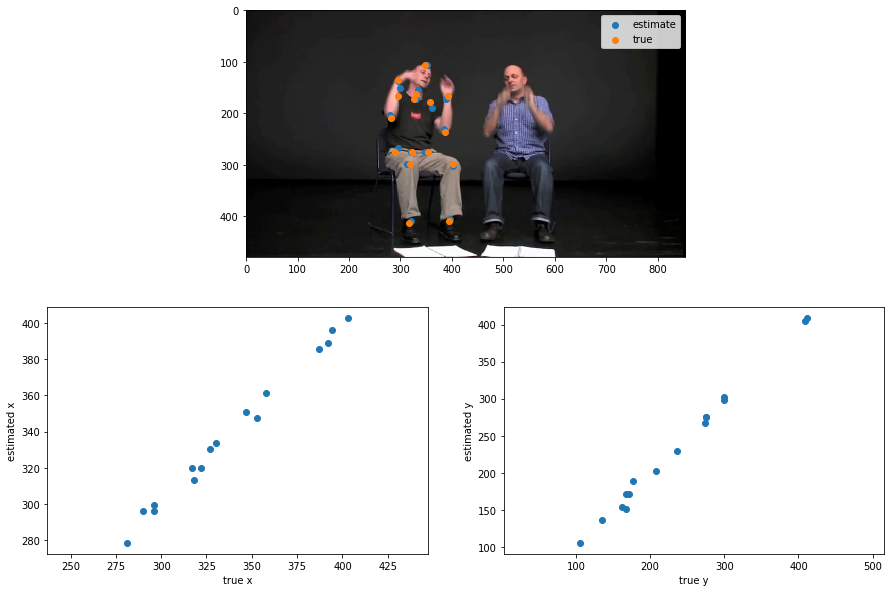

In [52]:
idx_sample = 1

# read and plot image
im = cv2.imread(image_path[idx_sample])
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.imshow(im[:,:,::-1])

# plot estimates joints
plt.scatter(pos_pred_src[:,0,idx_sample], pos_pred_src[:,1,idx_sample])
plt.scatter(pos_gt_src[:,0,idx_sample], pos_gt_src[:,1,idx_sample])
plt.legend(['estimate', 'true'])

# # plot head box
# hbox = headboxes_src[:,:,idx_sample]

# plot estiamte vs. true
plt.subplot(223)
plt.scatter(pos_gt_src[:,0,idx_sample], pos_pred_src[:,0,idx_sample])
plt.xlabel('true x')
plt.ylabel('estimated x')
plt.axis('equal')
plt.subplot(224)
plt.scatter(pos_gt_src[:,1,idx_sample], pos_pred_src[:,1,idx_sample])
plt.xlabel('true y')
plt.ylabel('estimated y')
plt.axis('equal')

plt.savefig('result_{}.jpg'.format(idx_sample))

## predict for one image

1.8
(256, 256, 3)


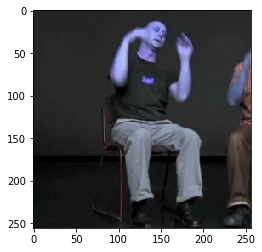

In [118]:
# preapre a scaled image
from utils.transforms import get_affine_transform

#center = np.array([im.shape[0]/2, im.shape[1]/2])
center = np.array([320, 270])
scale = 1.8
rot = 0
affine = get_affine_transform(center, scale, rot, [256,256])
input = cv2.warpAffine(
            im,
            affine,
            (256, 256),
            flags=cv2.INTER_LINEAR)

print(input.shape)
plt.imshow(input)

In [132]:
trans = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

im_tensor = trans(input)
print(im_tensor.shape)

with torch.no_grad():
    output = model(im_tensor.reshape([1, 3, 256, 256]))

print(output.shape)

torch.Size([3, 256, 256])
torch.Size([1, 16, 64, 64])


In [142]:
from core.inference import get_final_preds

pred, maxval = get_final_preds(cfg, output.clone().cpu().numpy(), [center], [scale])

pred.shape


1.8


(1, 16, 2)

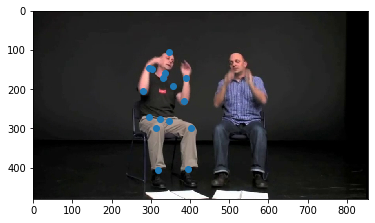

In [144]:
plt.imshow(im[:,:,::-1])
plt.scatter(pred[0,:,0], pred[0,:,1])